In [ ]:
!pip install pytorch-tabnet
import pandas as pd
import numpy  as np
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 870 kB/s 


In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=da7b5a43951080dc026d93036bd0904cd1ea755ee079e8ffb61c833fdeda503a
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

In [ ]:
csv_path = "/content/drive/Shareddrives/Topgun/data_that_includes_everything.csv"


Load data and split

In [ ]:
train = pd.read_csv(csv_path)
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index


In [ ]:
print(train.dtypes)

Simple preprocessing. 
잘 모르겠음,, 데이터 타입이 달라서ㅜ

In [ ]:
#fill the blank
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col)
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)


In [ ]:
target= "brix"
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

Network parameters

In [ ]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Training

In [ ]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [ ]:
max_epochs = 210 if not os.getenv("CI", False) else 2

In [ ]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 171.43321| train_rmsle: 3.78448 | train_mae: 26.12543| train_rmse: 31.68216| train_mse: 1003.75901| valid_rmsle: 3.33897 | valid_mae: 17.95264| valid_rmse: 19.53054| valid_mse: 381.44183|  0:00:00s
epoch 1  | loss: 163.98494| train_rmsle: 0.90959 | train_mae: 12.56177| train_rmse: 20.35375| train_mse: 414.27509| valid_rmsle: 0.92762 | valid_mae: 16.06963| valid_rmse: 23.24836| valid_mse: 540.48633|  0:00:00s
epoch 2  | loss: 159.25465| train_rmsle: 1.04825 | train_mae: 23.10796| train_rmse: 27.3676 | train_mse: 748.98543| valid_rmsle: 1.03637 | valid_mae: 24.21131| valid_rmse: 28.09023| valid_mse: 789.06119|  0:00:00s
epoch 3  | loss: 150.5573| train_rmsle: 1.96948 | train_mae: 48.65606| train_rmse: 85.31156| train_mse: 7278.06294| valid_rmsle: 2.82306 | valid_mae: 76.89361| valid_rmse: 120.44354| valid_mse: 14506.64633|  0:00:00s
epoch 4  | loss: 145.603 | train_rmsle: 1.97582 | train_mae: 49.48412| train_rmse: 87.18588| train_mse: 7601.37693| valid_rmsle: 1.54187 | v

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
print(clf)

TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[5, 4, 3, 6, 2, 2, 1, 10], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=55, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)


In [ ]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true) #MSE

dataset_name = "allApple"
print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")

BEST VALID SCORE FOR allApple : 1.0271841593662734
FINAL TEST SCORE FOR allApple : 2.6039192697497575


In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR allApple : 2.6039192697497575


In [ ]:
assert(test_score == loaded_test_mse)

Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 4.35585549e-04, 1.59472059e-01,
       1.25040575e-05, 3.08357649e-02, 2.20844869e-02, 9.74221735e-02,
       0.00000000e+00, 0.00000000e+00, 8.25557248e-04, 6.83360736e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.65319533e-02, 0.00000000e+00,
       3.77240946e-03, 0.00000000e+00, 0.00000000e+00, 8.24618991e-04,
       0.00000000e+00, 0.00000000e+00, 1.52867667e-02, 0.00000000e+00,
       7.42921716e-02, 6.56342872e-02, 8.56358078e-03, 1.25711789e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.77899423e-01,
       1.69263601e-03, 1.85126219e-02, 1.83214459e-02, 0.00000000e+00,
       0.00000000e+00, 6.58362631e-03, 0.00000000e+00, 0.00000000e+00,
       6.01524906e-03, 0.00000000e+00, 1.10047890e-02, 1.12217847e-02,
       0.00000000e+00, 4.30460658e-02, 0.00000000e+00, 0.00000000e+00,
       2.64769819e-03, 0.00000000e+00, 3.01287798e-03])

Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

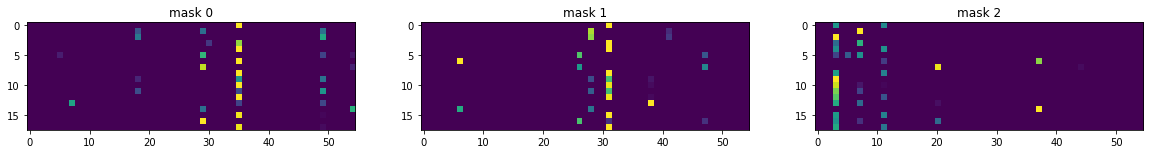

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

XGB

In [ ]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:11.5698
Will train until validation_0-rmse hasn't improved in 40 rounds.
[10]	validation_0-rmse:4.22168
[20]	validation_0-rmse:1.84508
[30]	validation_0-rmse:1.24047
[40]	validation_0-rmse:1.13455
[50]	validation_0-rmse:1.14045
[60]	validation_0-rmse:1.15115
[70]	validation_0-rmse:1.15277
[80]	validation_0-rmse:1.1607
Stopping. Best iteration:
[42]	validation_0-rmse:1.12364



XGBRegressor(max_depth=8, n_estimators=1000, n_jobs=-1, subsample=0.7,
             verbosity=0)

In [ ]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

1.262564741039033
2.108831329979667
